In [25]:
# ---------------------------------------------
# Step 1: Import the necessary libraries
# ---------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Fix the random seed so we get the same results each time (for reproducibility)
torch.manual_seed(42)


In [50]:
# ---------------------------------------------
# Step 2: Create a simple sequential dataset
# ---------------------------------------------
# Each sample will be a sequence of 100 random numbers (like a short time series)


n_samples = 200       # total number of sequences
seq_len = 50       # how many time steps in each sequence
features = 1          # each time step has only 1 feature

# Create 200 random sequences, each with 100 numbers between 0 and 1
first_vals = torch.rand(n_samples, 1, 1)
noise = 0.1 * torch.rand(n_samples, seq_len, 1)
X = first_vals + noise               # later values similar to the first one
y = (first_vals[:, 0, 0] > 0.5).float()


# Combine data and labels into a TensorDataset
dataset = TensorDataset(X, y)

# Use a DataLoader to iterate through the data in small batches (helps training)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [52]:
# ---------------------------------------------
# Step 3: Define the LSTM Model
# ---------------------------------------------
class SimpleLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        # LSTM layer:
        # input_size = 1 → each time step has 1 feature (a single number)
        # hidden_size = 64 → the LSTM will have 64 hidden neurons (memory cells)
        # batch_first=True → input shape = (batch_size, seq_length, features)
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)

        #  Fully connected layer:
        # Takes the last output from the LSTM and maps it to 1 output neuron (0 or 1)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        # The LSTM processes the input sequence and returns two things:
        # 'out' → outputs for all time steps
        # '(h, c)' → the final hidden and cell states 
        out, (h, c) = self.lstm(x)

        # We only care about the output of the LAST time step
        # because we want to predict ONE label per sequence.
        last_out = out[:, -1, :]

        # Pass this through the final fully connected (linear) layer
        # to get the final prediction (logit).
        return self.fc(last_out)



In [53]:
# ---------------------------------------------
# Step 4: Initialize model, loss, and optimizer
# ---------------------------------------------
model = SimpleLSTM()

# BCEWithLogitsLoss combines a Sigmoid layer + Binary Cross Entropy loss
# It's used for binary classification (0/1 tasks) and is more numerically stable.
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer automatically adjusts learning rate during training.
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [54]:
# ---------------------------------------------
# Step 5: Train the model
# ---------------------------------------------
loss_history = []  # to store average loss per epoch (for visualization)

for epoch in range(30):   # we'll train for 30 rounds (epochs)
    total_loss = 0

    # Go through each batch of 16 sequences
    for batch_x, batch_y in loader:
        optimizer.zero_grad()          # Reset gradients from previous step
        preds = model(batch_x)         # Model predicts outputs (logits)

        batch_y = batch_y.view(-1, 1)  # Reshape labels to match prediction shape

        loss = criterion(preds, batch_y)  # Compare predictions to true labels

        loss.backward()                # Compute gradients for all weights
        optimizer.step()               # Update the weights (learning happens here)

        total_loss += loss.item()      # Keep track of total loss for this epoch

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)

    # Print progress
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")


Epoch 1 | Loss: 0.6848
Epoch 2 | Loss: 0.6689
Epoch 3 | Loss: 0.5656
Epoch 4 | Loss: 0.2851
Epoch 5 | Loss: 0.3445
Epoch 6 | Loss: 0.3735
Epoch 7 | Loss: 0.3978
Epoch 8 | Loss: 0.4657
Epoch 9 | Loss: 0.5451
Epoch 10 | Loss: 0.4765
Epoch 11 | Loss: 0.4192
Epoch 12 | Loss: 0.3708
Epoch 13 | Loss: 0.3499
Epoch 14 | Loss: 0.3319
Epoch 15 | Loss: 0.2141
Epoch 16 | Loss: 0.2103
Epoch 17 | Loss: 0.1600
Epoch 18 | Loss: 0.0730
Epoch 19 | Loss: 0.0522
Epoch 20 | Loss: 0.0304
Epoch 21 | Loss: 0.0236
Epoch 22 | Loss: 0.0193
Epoch 23 | Loss: 0.0156
Epoch 24 | Loss: 0.0131
Epoch 25 | Loss: 0.0113
Epoch 26 | Loss: 0.0098
Epoch 27 | Loss: 0.0088
Epoch 28 | Loss: 0.0079
Epoch 29 | Loss: 0.0071
Epoch 30 | Loss: 0.0065


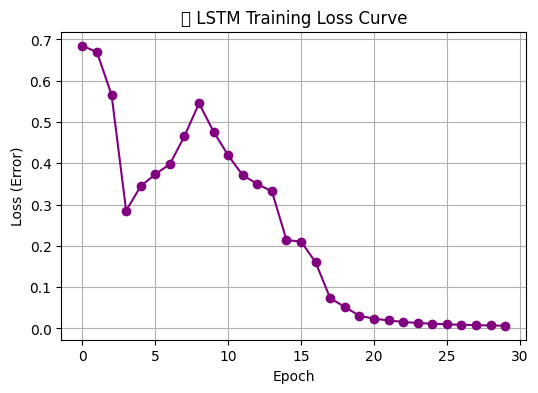

In [55]:
# ---------------------------------------------
#  Step 6: Visualize the training loss
# ---------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o', color='purple')
plt.title("📊 LSTM Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss (Error)")
plt.grid(True)
plt.show()

# Expected: The purple line should go down over time → loss decreases as model learns.


In [56]:
# ---------------------------------------------
# Step 7: Evaluate model accuracy
# ---------------------------------------------
# We now check how well the trained model performs on all data.

model.eval()  # Put model into evaluation mode (turns off dropout, etc.)

with torch.no_grad():  # No gradient computation needed (faster)
    preds = torch.sigmoid(model(X)).squeeze()  # Apply sigmoid to get probabilities (0–1)

# Convert probabilities into 0 or 1 predictions
pred_labels = (preds > 0.5).float()

# Calculate accuracy: compare predicted labels to true labels
acc = (pred_labels == y).float().mean().item()
print(f"LSTM Accuracy: {acc*100:.2f}%")



LSTM Accuracy: 100.00%
